In [7]:
import sys
import os
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import pandas as pd
from tqdm import tqdm

In [8]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

GNDTRUTH = Path('../data/raw/COMMON_images_masks/')
RAWIMGS = Path('../data/raw/GROUP_images/')
COMMONIMGS = Path('../data/raw/COMMON_images_masks/')
REGS = Path('../data/registered')
DATA = (RAWIMGS.parent).parent
MASKS = DATA/'masks'
OUTPUT = DATA/'atlas_segmentation'
OUTPUT.mkdir(exist_ok=True)

print(f"\nPaths:")
print(f"  Ground truth: {GNDTRUTH}")
print(f"  Registrations: {REGS}")
print(f"  Masks: {MASKS}")
print(f"  Output: {OUTPUT}")


Paths:
  Ground truth: ..\data\raw\COMMON_images_masks
  Registrations: ..\data\registered
  Masks: ..\data\masks
  Output: ..\data\atlas_segmentation


In [9]:
def load_transform(transform_path):
    """load a transform from a file"""
    if not transform_path.exists():
        raise FileNotFoundError(f"Transform not found: {transform_path}")
    return sitk.ReadTransform(str(transform_path))

In [ ]:
def apply_transform_to_mask(mask, transform, reference_image):
    """
    apply transform to mask
    
    Parameters:
    -----------
    mask : SimpleITK.Image
        mask to be transformed
    transform : SimpleITK.Transform
        transform to be applied
    reference_image : SimpleITK.Image
        reference image for resampling
        
    Returns:
    --------
    transformed_mask : SimpleITK.Image
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetTransform(transform)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # keep label integrity
    resampler.SetDefaultPixelValue(0)
    
    return resampler.Execute(mask)

In [ ]:
def majority_voting(masks):
    """
    majority voting to fuse multiple masks
    
    Parameters:
    -----------
    masks : list of SimpleITK.Image
        masks to be fused
        
    Returns:
    --------
    result_mask : SimpleITK.Image
        fused mask
    """
    if len(masks) == 0:
        raise ValueError("No masks provided for majority voting")
    
    # transform masks to numpy arrays
    arrays = [sitk.GetArrayFromImage(mask) for mask in masks]
    
    # stack arrays
    stacked = np.stack(arrays, axis=0)
    
    # majority voting
    threshold = len(masks) / 2.0
    voted = np.sum(stacked > 0, axis=0) >= threshold
    
    # convert back to SimpleITK image
    result = sitk.GetImageFromArray(voted.astype(np.uint8))
    result.CopyInformation(masks[0])
    
    return result

In [ ]:
def dice_coefficient(mask1, mask2):
    """
    Compute Dice coefficient
    
    Parameters:
    -----------
    mask1, mask2 : SimpleITK.Image
        2 masks to compare
        
    Returns:
    --------
    dice : float
        Dice parameter (0-1)
    """
    arr1 = sitk.GetArrayFromImage(mask1) > 0
    arr2 = sitk.GetArrayFromImage(mask2) > 0
    
    intersection = np.sum(arr1 & arr2)
    union = np.sum(arr1) + np.sum(arr2)
    
    if union == 0:
        return 0.0
    
    return 2.0 * intersection / union


def hausdorff_distance(mask1, mask2):
    """
    Compute Hausdorff distance
    
    Parameters:
    -----------
    mask1, mask2 : SimpleITK.Image
        2 masks to compare
        
    Returns:
    --------
    hd : float
        Hausdorff distance (mm)
    """
    hausdorff_filter = sitk.HausdorffDistanceImageFilter()
    
    mask1_binary = sitk.Cast(mask1 > 0, sitk.sitkUInt8)
    mask2_binary = sitk.Cast(mask2 > 0, sitk.sitkUInt8)
    
    try:
        hausdorff_filter.Execute(mask1_binary, mask2_binary)
        return hausdorff_filter.GetHausdorffDistance()
    except:
        return np.nan

In [13]:

def seg_atlas(reference_image_name, atlas_names, transform_suffix="bspline"):
    """
    Atlas-based segmentation for one reference (fixed) image.

    transform_suffix:
      - 'linear'  : apply only linear transform
      - 'bspline' : apply composite transform (linear + bspline),
                   because bspline was estimated AFTER linear-resampling.
    """
    print(f"\n{'='*60}")
    print(f"Atlas-based segmentation for {reference_image_name}")
    print(f"{'='*60}")

    # 1) read fixed (reference) image
    ref_image_path = GNDTRUTH / f"{reference_image_name}_image.nii.gz"
    if not ref_image_path.exists():
        raise FileNotFoundError(f"Reference image not found: {ref_image_path}")

    reference_image = sitk.ReadImage(str(ref_image_path))
    print(f"Reference image loaded: {reference_image.GetSize()}")

    # 2) apply transforms to each atlas mask
    transformed_masks = []

    for atlas_name in atlas_names:
        print(f"\nProcessing atlas: {atlas_name}")

        atlas_mask_path = MASKS / f"{atlas_name}_mask.nii.gz"
        if not atlas_mask_path.exists():
            print(f"  ⚠️  Warning: Atlas mask not found: {atlas_mask_path}")
            continue

        atlas_mask = sitk.ReadImage(str(atlas_mask_path))
        nz0 = int(np.sum(sitk.GetArrayFromImage(atlas_mask) > 0))
        print(f"  Atlas mask loaded: {nz0} non-zero voxels")

        # -------- choose transform --------
        if transform_suffix == "linear":
            transform_path = REGS / f"{atlas_name}_to_{reference_image_name}_linear.tfm"
            if not transform_path.exists():
                print(f"  ⚠️  Warning: Transform not found: {transform_path}")
                continue

            transform = load_transform(transform_path)
            print(f"  Transform loaded (linear): {transform.GetName()}")

        elif transform_suffix == "bspline":
            # IMPORTANT: bspline was estimated on linear-resampled moving,
            # so apply original -> linear -> bspline
            linear_path  = REGS / f"{atlas_name}_to_{reference_image_name}_linear.tfm"
            bspline_path = REGS / f"{atlas_name}_to_{reference_image_name}_bspline.tfm"

            if (not linear_path.exists()) or (not bspline_path.exists()):
                print(f"  ⚠️  Warning: Missing transforms:\n    {linear_path}\n    {bspline_path}")
                continue

            linear_tfm  = load_transform(linear_path)
            bspline_tfm = load_transform(bspline_path)

            composite = sitk.CompositeTransform(3)
            # order matters: first linear, then bspline
            composite.AddTransform(linear_tfm)
            composite.AddTransform(bspline_tfm)
            transform = composite

            print("  Transform loaded (composite): linear + bspline")

        else:
            raise ValueError("transform_suffix must be 'linear' or 'bspline'")

        # -------- apply transform to mask --------
        transformed_mask = apply_transform_to_mask(atlas_mask, transform, reference_image)
        nz = int(np.sum(sitk.GetArrayFromImage(transformed_mask) > 0))
        print(f"  Transformed mask: {nz} non-zero voxels")

        if nz > 0:
            transformed_masks.append(transformed_mask)
        else:
            print("  ⚠️  Warning: Transformed mask is empty!")

    # 3) majority voting
    if len(transformed_masks) == 0:
        raise ValueError("No valid transformed masks for majority voting")

    print(f"\nPerforming majority voting with {len(transformed_masks)} masks...")
    result_mask = majority_voting(transformed_masks)

    result_voxels = int(np.sum(sitk.GetArrayFromImage(result_mask) > 0))
    print(f"Result mask: {result_voxels} non-zero voxels")

    # 4) save
    output_path = OUTPUT / f"{reference_image_name}_atlas_segmentation_{transform_suffix}.nii.gz"
    sitk.WriteImage(result_mask, str(output_path))
    print(f"\n✓ Saved to: {output_path}")

    return result_mask


In [ ]:


# configuration
COMMON_IMAGES = ['common_40', 'common_41', 'common_42']
ATLAS_IMAGES = ['g1_54', 'g1_55', 'g1_56']
TRANSFORM_TYPE = 'bspline'  # 'linear' or 'bspline'

print(f"\nConfiguration:")
print(f"  Common images: {COMMON_IMAGES}")
print(f"  Atlas images: {ATLAS_IMAGES}")
print(f"  Transform type: {TRANSFORM_TYPE}")

# Execute atlas-based segmentation
atlas_results = {}

for common_name in COMMON_IMAGES:
    try:
        result_mask = seg_atlas(common_name, ATLAS_IMAGES, TRANSFORM_TYPE)
        atlas_results[common_name] = result_mask
        print(f"\n✓ {common_name} completed successfully")
    except Exception as e:
        print(f"\n✗ {common_name} failed: {e}")
        atlas_results[common_name] = None

print("\n" + "="*60)
print("BATCH PROCESSING COMPLETED")
print(f"Success: {sum(1 for v in atlas_results.values() if v is not None)}/{len(COMMON_IMAGES)}")
print("="*60)


Configuration:
  Common images: ['common_40', 'common_41', 'common_42']
  Atlas images: ['g1_54', 'g1_55', 'g1_56']
  Transform type: bspline

Atlas-based segmentation for common_40
Reference image loaded: (512, 512, 286)

Processing atlas: g1_54
  Atlas mask loaded: 1149516 non-zero voxels
  Transform loaded (composite): linear + bspline
  Transformed mask: 1115229 non-zero voxels

Processing atlas: g1_55
  Atlas mask loaded: 1287914 non-zero voxels
  Transform loaded (composite): linear + bspline
  Transformed mask: 1184680 non-zero voxels

Processing atlas: g1_56
  Atlas mask loaded: 1167372 non-zero voxels
  Transform loaded (composite): linear + bspline
  Transformed mask: 1165826 non-zero voxels

Performing majority voting with 3 masks...
Result mask: 1121857 non-zero voxels

✓ Saved to: ..\data\atlas_segmentation\common_40_atlas_segmentation_bspline.nii.gz

✓ common_40 completed successfully

Atlas-based segmentation for common_41
Reference image loaded: (512, 512, 300)

Proces

In [ ]:
results_data = []

for common_name in COMMON_IMAGES:
    print(f"\n{'='*60}")
    print(f"Evaluating {common_name}")
    print(f"{'='*60}")
    
    # load ground truth
    gt_path = GNDTRUTH / f'{common_name}_masks_right_hip_femur_only.nii.gz'
    if not gt_path.exists():
        print(f"⚠️  Ground truth not found: {gt_path}")
        continue
    
    gt_mask = sitk.ReadImage(str(gt_path))
    print(f"Ground truth loaded: {np.sum(sitk.GetArrayFromImage(gt_mask) > 0)} voxels")
    
    # 1. evaluate Manual segmentation
    manual_path = MASKS / f'{common_name}_regmask.nii.gz'
    if manual_path.exists():
        manual_mask = sitk.ReadImage(str(manual_path))
        
        dice_manual = dice_coefficient(gt_mask, manual_mask)
        hd_manual = hausdorff_distance(gt_mask, manual_mask)
        
        print(f"\nManual Segmentation (Task 1):")
        print(f"  Dice: {dice_manual:.4f}")
        print(f"  Hausdorff: {hd_manual:.2f} mm")
        
        results_data.append({
            'Image': common_name,
            'Method': 'Manual',
            'Dice': dice_manual,
            'Hausdorff': hd_manual
        })
    else:
        print(f"\n⚠️  Manual segmentation not found: {manual_path}")
    
    # 2. evaluate Atlas-based segmentation
    if atlas_results.get(common_name) is not None:
        atlas_mask = atlas_results[common_name]
        
        dice_atlas = dice_coefficient(gt_mask, atlas_mask)
        hd_atlas = hausdorff_distance(gt_mask, atlas_mask)
        
        print(f"\nAtlas-based Segmentation (Task 3):")
        print(f"  Dice: {dice_atlas:.4f}")
        print(f"  Hausdorff: {hd_atlas:.2f} mm")
        
        results_data.append({
            'Image': common_name,
            'Method': 'Atlas-based',
            'Dice': dice_atlas,
            'Hausdorff': hd_atlas
        })


Evaluating common_40
Ground truth loaded: 1197012 voxels

Manual Segmentation (Task 1):
  Dice: 0.9694
  Hausdorff: 4.79 mm

Atlas-based Segmentation (Task 3):
  Dice: 0.9032
  Hausdorff: 15.37 mm

Evaluating common_41
Ground truth loaded: 923628 voxels

Manual Segmentation (Task 1):
  Dice: 0.9735
  Hausdorff: 5.89 mm

Atlas-based Segmentation (Task 3):
  Dice: 0.9042
  Hausdorff: 17.47 mm

Evaluating common_42
Ground truth loaded: 1102677 voxels

Manual Segmentation (Task 1):
  Dice: 0.9685
  Hausdorff: 11.73 mm

Atlas-based Segmentation (Task 3):
  Dice: 0.9182
  Hausdorff: 6.91 mm


In [ ]:
df_results = pd.DataFrame(results_data)

# display detailed results
print("\n" + "-"*60)
print("Detailed Results:")
print("-"*60)
print(df_results.to_string(index=False))

# statistical summary
print("\n" + "-"*60)
print("Statistical Summary:")
print("-"*60)

if len(df_results) > 0:
    summary = df_results.groupby('Method').agg({
        'Dice': ['mean', 'std', 'min', 'max'],
        'Hausdorff': ['mean', 'std', 'min', 'max']
    })
    print(summary)
    
    # save results
    df_results.to_csv(OUTPUT / 'accuracy_assessment.csv', index=False)
    print(f"\n✓ Results saved to: {OUTPUT / 'accuracy_assessment.csv'}")


------------------------------------------------------------
Detailed Results:
------------------------------------------------------------
    Image      Method     Dice  Hausdorff
common_40      Manual 0.969419   4.788623
common_40 Atlas-based 0.903197  15.368477
common_41      Manual 0.973460   5.886810
common_41 Atlas-based 0.904242  17.467246
common_42      Manual 0.968532  11.725938
common_42 Atlas-based 0.918240   6.914974

------------------------------------------------------------
Statistical Summary:
------------------------------------------------------------
                Dice                               Hausdorff            \
                mean       std       min      max       mean       std   
Method                                                                   
Atlas-based  0.90856  0.008400  0.903197  0.91824  13.250232  5.585950   
Manual       0.97047  0.002627  0.968532  0.97346   7.467124  3.728891   

                                  
               

✓ Comparison plot saved to: ..\data\atlas_segmentation\accuracy_comparison.png


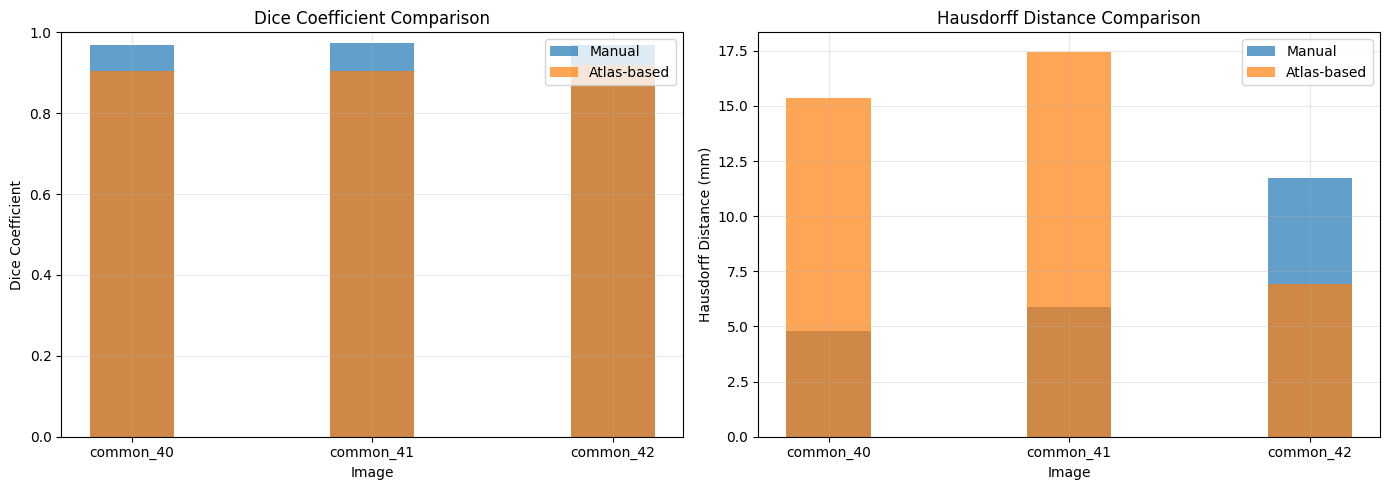

In [22]:
if len(df_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Dice comparison
    for method in df_results['Method'].unique():
        method_data = df_results[df_results['Method'] == method]
        axes[0].bar(method_data['Image'], method_data['Dice'], 
                   alpha=0.7, label=method, width=0.35)
    
    axes[0].set_xlabel('Image')
    axes[0].set_ylabel('Dice Coefficient')
    axes[0].set_title('Dice Coefficient Comparison')
    axes[0].legend()
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3)
    
    # Hausdorff comparison
    for method in df_results['Method'].unique():
        method_data = df_results[df_results['Method'] == method]
        axes[1].bar(method_data['Image'], method_data['Hausdorff'], 
                   alpha=0.7, label=method, width=0.35)
    
    axes[1].set_xlabel('Image')
    axes[1].set_ylabel('Hausdorff Distance (mm)')
    axes[1].set_title('Hausdorff Distance Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT / 'accuracy_comparison.png', dpi=150, bbox_inches='tight')
    print(f"✓ Comparison plot saved to: {OUTPUT / 'accuracy_comparison.png'}")
    plt.show()

In [ ]:
# Visualize segmentation results
def visualize_segmentation_results(image_name):
    """
    Visualize segmentation for one image (coronal view by fixing Y index).
    """

    # --- Read image ---
    img_path = GNDTRUTH / f'{image_name}_image.nii.gz'
    if not img_path.exists():
        raise FileNotFoundError(f"Image not found: {img_path}")

    img = sitk.ReadImage(str(img_path))
    img_arr = sitk.GetArrayFromImage(img)  # (z, y, x)

    # --- Paths ---
    gt_path     = GNDTRUTH / f'{image_name}_masks_right_hip_femur_only.nii.gz'
    atlas_path  = OUTPUT   / f'{image_name}_atlas_segmentation_bspline.nii.gz'
    manual_path = MASKS    / f'{image_name}_regmask.nii.gz'

    # --- Debug existence ---
    print(f"\n[{image_name}] paths check:")
    print(f"  GT     : {gt_path}    exists={gt_path.exists()}")
    print(f"  Atlas  : {atlas_path} exists={atlas_path.exists()}")
    print(f"  Manual : {manual_path} exists={manual_path.exists()}")

    # --- Read masks ---
    gt_mask     = sitk.ReadImage(str(gt_path)) if gt_path.exists() else None
    atlas_mask  = sitk.ReadImage(str(atlas_path)) if atlas_path.exists() else None
    manual_mask = sitk.ReadImage(str(manual_path)) if manual_path.exists() else None

    gt_arr     = sitk.GetArrayFromImage(gt_mask) if gt_mask is not None else None
    atlas_arr  = sitk.GetArrayFromImage(atlas_mask) if atlas_mask is not None else None
    manual_arr = sitk.GetArrayFromImage(manual_mask) if manual_mask is not None else None

    # --- Extra debug ---
    if gt_arr is not None:
        print(f"  GT nonzero voxels: {np.sum(gt_arr > 0)}")
    if atlas_arr is not None:
        print(f"  Atlas nonzero voxels: {np.sum(atlas_arr > 0)}")
    if manual_arr is not None:
        print(f"  Manual nonzero voxels: {np.sum(manual_arr > 0)}")

    def show_slice(slc):
        n_plots = 2 + (1 if manual_arr is not None else 0)
        fig, axes = plt.subplots(2, n_plots, figsize=(6 * n_plots, 10))

        # --- helper ---
        def sl(arr):
            return arr[:, slc, :]  # coronal

        gt2    = (sl(gt_arr) > 0).astype(np.uint8) if gt_arr is not None else None
        atlas2 = (sl(atlas_arr) > 0).astype(np.uint8) if atlas_arr is not None else None
        man2   = (sl(manual_arr) > 0).astype(np.uint8) if manual_arr is not None else None
        img2   = sl(img_arr)

        # --- base image ---
        for ax in axes.ravel():
            ax.imshow(img2, cmap='gray', vmin=-200, vmax=400)
            ax.axis('off')

        # ================= Row 1 =================
        axes[0, 0].set_title('Ground Truth')
        if gt2 is not None:
            axes[0, 0].contour(gt2, levels=[0.5], linewidths=2.5)

        axes[0, 1].set_title('Atlas-based Segmentation')
        if atlas2 is not None:
            axes[0, 1].contour(atlas2, levels=[0.5], linewidths=2.5)

        if manual_arr is not None:
            axes[0, 2].set_title('Manual Segmentation')
            if man2 is not None:
                axes[0, 2].contour(man2, levels=[0.5], linewidths=2.5)

        # ================= Row 2 =================
        axes[1, 0].set_title('GT vs Atlas')
        if gt2 is not None:
            axes[1, 0].contour(gt2, levels=[0.5], linewidths=2.0)
        if atlas2 is not None:
            axes[1, 0].contour(atlas2, levels=[0.5], linewidths=2.0)

        axes[1, 1].set_title('Error Map (FP/FN)')
        if gt2 is not None and atlas2 is not None:
            fp = (gt2 == 0) & (atlas2 == 1)
            fn = (gt2 == 1) & (atlas2 == 0)

            axes[1, 1].imshow(np.ma.masked_where(~fp, fp), alpha=0.55)
            axes[1, 1].imshow(np.ma.masked_where(~fn, fn), alpha=0.55)
            axes[1, 1].contour(fp.astype(np.uint8), levels=[0.5], linewidths=1.5)
            axes[1, 1].contour(fn.astype(np.uint8), levels=[0.5], linewidths=1.5)

        if manual_arr is not None:
            axes[1, 2].set_title('GT vs Manual')
            if gt2 is not None:
                axes[1, 2].contour(gt2, levels=[0.5], linewidths=2.0)
            if man2 is not None:
                axes[1, 2].contour(man2, levels=[0.5], linewidths=2.0)

        plt.suptitle(f'{image_name} - Coronal Slice {slc}',
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    widget = interact(
        show_slice,
        slc=IntSlider(
            min=0,
            max=img_arr.shape[1] - 1,
            step=1,
            value=img_arr.shape[1] // 2
        )
    )
    display(widget)
    return widget

In [ ]:

# create visualizations for each common image
print("\nGenerating interactive visualizations...")
for common_name in COMMON_IMAGES:
    print(f"\n{common_name}:")
    try:
        visualize_segmentation_results(common_name)
    except Exception as e:
        print(f"  ✗ Visualization failed: {e}")


Generating interactive visualizations...

common_40:

[common_40] paths check:
  GT     : ..\data\raw\COMMON_images_masks\common_40_masks_right_hip_femur_only.nii.gz    exists=True
  Atlas  : ..\data\atlas_segmentation\common_40_atlas_segmentation_bspline.nii.gz exists=True
  Manual : ..\data\masks\common_40_regmask.nii.gz exists=True
  GT nonzero voxels: 1197012
  Atlas nonzero voxels: 1121857
  Manual nonzero voxels: 1136547


interactive(children=(IntSlider(value=256, description='slc', max=511), Output()), _dom_classes=('widget-inter…

<function __main__.visualize_segmentation_results.<locals>.show_slice(slc)>


common_41:

[common_41] paths check:
  GT     : ..\data\raw\COMMON_images_masks\common_41_masks_right_hip_femur_only.nii.gz    exists=True
  Atlas  : ..\data\atlas_segmentation\common_41_atlas_segmentation_bspline.nii.gz exists=True
  Manual : ..\data\masks\common_41_regmask.nii.gz exists=True
  GT nonzero voxels: 923628
  Atlas nonzero voxels: 888556
  Manual nonzero voxels: 890213


interactive(children=(IntSlider(value=256, description='slc', max=511), Output()), _dom_classes=('widget-inter…

<function __main__.visualize_segmentation_results.<locals>.show_slice(slc)>


common_42:

[common_42] paths check:
  GT     : ..\data\raw\COMMON_images_masks\common_42_masks_right_hip_femur_only.nii.gz    exists=True
  Atlas  : ..\data\atlas_segmentation\common_42_atlas_segmentation_bspline.nii.gz exists=True
  Manual : ..\data\masks\common_42_regmask.nii.gz exists=True
  GT nonzero voxels: 1102677
  Atlas nonzero voxels: 1085258
  Manual nonzero voxels: 1073277


interactive(children=(IntSlider(value=256, description='slc', max=511), Output()), _dom_classes=('widget-inter…

<function __main__.visualize_segmentation_results.<locals>.show_slice(slc)>